In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

DB_FILE_PATH = 'db.sqlite3'
SELECT_SQL = 'SELECT * FROM blog_accesslog'
ANALYTICS_IMAGE_FILE_PATH = 'static/accessAnalytics/images/'

def create_connection(db_file_path):
    conn = None
    try:
        conn = sqlite3.connect(db_file_path)
    except sqlite3.Error as e:
        print(e)
    return conn

In [2]:
conn = create_connection(DB_FILE_PATH)
df = pd.read_sql_query(SELECT_SQL, conn)
conn.close()
df.head()

,id,blog_pk,blog_name,blog_owner,blog_url,uuId,ip,page,user,timezone,language,device,now,referer,browser
0,1,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 20:27:35,http://192.168.33.11:8000/login/?next=/takizawa/,Chrome
1,2,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 20:28:05,http://192.168.33.11:8000/mypage/,Chrome
2,3,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 20:53:22,http://192.168.33.11:8000/mypage/design_custom...,Chrome
3,4,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/186bda5a-814...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 21:08:59,http://192.168.33.11:8000/,Chrome
4,5,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/186bda5a-814...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 21:26:56,http://192.168.33.11:8000/,Chrome


In [3]:
# ブログタイトルで絞る

blog_all = df.groupby('blog_name')
blog_all.groups

{"takizawa's blog": Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')}

In [4]:
# ブログ毎のアクセスログの数

for k, v in blog_all:
    print(k + ' : ' + str(len(v)))

takizawa's blog : 16


In [5]:
# ブログ毎のアクセスログをuuid,nowだけ摘出し、seriesとしてリストに格納

blog_group_list = []
for k,v in blog_all:
    df_blog_group = pd.concat([v.uuId, v.now], axis=1)
    blog_group_list.append(df_blog_group)

In [6]:
# 列名をnowからtimeに変更し、日時計算のためにdatetime型に変換

cnt = 0

for i in blog_group_list:
    blog_group_list[cnt] = i.rename(columns={'now': 'time'})
    blog_group_list[cnt]['time'] = pd.to_datetime(blog_group_list[cnt]['time'])
    cnt += 1

In [7]:
# uuid毎に絞る

blog_group_uuid_list = []
for i in blog_group_list:
    i = i.groupby('uuId')
    blog_group_uuid_list.append(i)

In [8]:
blog_group_uuid_list[0].groups

{'551ff57d74c24c13b351dfba1a243178': Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64'),
 'dc2e034b1a624c2ab81c090a74f493c7': Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')}

In [9]:
# ブログ毎、UUID毎にユーザーの滞在時間を計算し、リストに格納

blog_group_uuid_time_list = []

for i in blog_group_uuid_list:
    for k, v in i:
        s = (v['time'].shift(-1) - v['time']).dt.total_seconds()
        blog_group_uuid_time_list.append(s)
blog_group_uuid_time_list

[7      14.0
 8     153.0
 9     197.0
 10    488.0
 11    626.0
 12    141.0
 13    512.0
 14     39.0
 15      NaN
 Name: time, dtype: float64, 0      30.0
 1    1517.0
 2     937.0
 3    1077.0
 4    1129.0
 5       2.0
 6       NaN
 Name: time, dtype: float64]

In [10]:
len(blog_group_uuid_time_list)

2

In [11]:
# リストに格納した滞在時間のデータをseriesに変換

blog_group_uuid_time_series = None
for i in range(0, len(blog_group_uuid_time_list)):
    blog_group_uuid_time_series = pd.concat([blog_group_uuid_time_series, blog_group_uuid_time_list[i]])
# df_time1_series = pd.concat([df_time1_list[0], df_time1_list[1]], axis=0)
blog_group_uuid_time_series

7       14.0
8      153.0
9      197.0
10     488.0
11     626.0
12     141.0
13     512.0
14      39.0
15       NaN
0       30.0
1     1517.0
2      937.0
3     1077.0
4     1129.0
5        2.0
6        NaN
Name: time, dtype: float64

In [12]:
blog_group_uuid_time_series.size

16

In [13]:
# 元のデータフレームに滞在時間を結合する

df_time = pd.concat([df, blog_group_uuid_time_series], axis=1, join='outer')
df_time['time'] = df_time['time'].fillna(0)
df_time['time'] = df_time['time'].astype(np.int64)
df_time

,id,blog_pk,blog_name,blog_owner,blog_url,uuId,ip,page,user,timezone,language,device,now,referer,browser,time
0,1,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 20:27:35,http://192.168.33.11:8000/login/?next=/takizawa/,Chrome,30
1,2,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 20:28:05,http://192.168.33.11:8000/mypage/,Chrome,1517
2,3,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 20:53:22,http://192.168.33.11:8000/mypage/design_custom...,Chrome,937
3,4,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/186bda5a-814...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 21:08:59,http://192.168.33.11:8000/,Chrome,1077
4,5,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/186bda5a-814...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 21:26:56,http://192.168.33.11:8000/,Chrome,1129
5,6,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/e0626032-d61...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 21:45:45,http://192.168.33.11:8000/,Chrome,2
6,7,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14 21:45:47,http://192.168.33.11:8000/takizawa/entry/e0626...,Chrome,0
7,8,1,takizawa's blog,takizawa,takizawa,551ff57d74c24c13b351dfba1a243178,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-20 21:04:58,http://192.168.33.11:8000/,Chrome,14
8,9,1,takizawa's blog,takizawa,takizawa,551ff57d74c24c13b351dfba1a243178,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-20 21:05:12,http://192.168.33.11:8000/,Chrome,153
9,10,1,takizawa's blog,takizawa,takizawa,551ff57d74c24c13b351dfba1a243178,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-20 21:07:45,http://192.168.33.11:8000/,Chrome,197


In [14]:
# 日時毎のアクセス数を求めるため、判別しやすいように年-月-日という形式の文字列に変換

df_time_day = df_time
df_time_day['now'] = df_time_day['now'].str[:10]
df_time_day 

,id,blog_pk,blog_name,blog_owner,blog_url,uuId,ip,page,user,timezone,language,device,now,referer,browser,time
0,1,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14,http://192.168.33.11:8000/login/?next=/takizawa/,Chrome,30
1,2,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14,http://192.168.33.11:8000/mypage/,Chrome,1517
2,3,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14,http://192.168.33.11:8000/mypage/design_custom...,Chrome,937
3,4,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/186bda5a-814...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14,http://192.168.33.11:8000/,Chrome,1077
4,5,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/186bda5a-814...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14,http://192.168.33.11:8000/,Chrome,1129
5,6,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/entry/e0626032-d61...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14,http://192.168.33.11:8000/,Chrome,2
6,7,1,takizawa's blog,takizawa,takizawa,dc2e034b1a624c2ab81c090a74f493c7,192.168.33.1,192.168.33.11:8000/takizawa/,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-14,http://192.168.33.11:8000/takizawa/entry/e0626...,Chrome,0
7,8,1,takizawa's blog,takizawa,takizawa,551ff57d74c24c13b351dfba1a243178,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-20,http://192.168.33.11:8000/,Chrome,14
8,9,1,takizawa's blog,takizawa,takizawa,551ff57d74c24c13b351dfba1a243178,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-20,http://192.168.33.11:8000/,Chrome,153
9,10,1,takizawa's blog,takizawa,takizawa,551ff57d74c24c13b351dfba1a243178,192.168.33.1,192.168.33.11:8000/takizawa/entry/296047c0-8c8...,takizawa,Asia/Tokyo,ja_JP.UTF-8,Macintosh,2020-02-20,http://192.168.33.11:8000/,Chrome,197


In [15]:
# ブログ毎に1週間の間の1日のユーザー数を求めるため、グループ分け

df_user = df_time_day.groupby(['blog_name', 'now', 'uuId'], as_index=False)
df_user.groups

{("takizawa's blog",
  '2020-02-14',
  'dc2e034b1a624c2ab81c090a74f493c7'): Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64'),
 ("takizawa's blog",
  '2020-02-20',
  '551ff57d74c24c13b351dfba1a243178'): Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')}

In [16]:
df_user_all = df_time_day.groupby(['blog_name', 'now'], as_index=False)
df_user_all.groups

{("takizawa's blog",
  '2020-02-14'): Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64'),
 ("takizawa's blog",
  '2020-02-20'): Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')}

In [17]:
# 今日から1週間分の空データを作成するためリストで1週間分の日時を保持

from datetime import datetime, timedelta

# today_str = '2020-02-19'
# today = datetime.strptime(today_str, '%Y-%m-%d')
today = datetime.today()

# テスト用で日付固定
# today_str = "2020-02-07"
# today = datetime.strptime(today_str, '%Y-%m-%d')

cnt = 6
week = []
for i in range(7):
    week.append((today - timedelta(days=cnt)).strftime('%Y-%m-%d'))
    cnt -= 1

week


# cnt = 3
# week = []
# for i in range(4):
#     week.append((today - timedelta(days=cnt)).strftime('%Y-%m-%d'))
#     cnt -= 1

# week

['2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23']

In [18]:
# ブログ毎の1週間のユーザー数
# 1週間分データに修正したバージョン

from collections import defaultdict
nested_dict = lambda: defaultdict(nested_dict)
days = nested_dict()

for k, v in df_user:
    if k[1] in week:
        if k[0] not in days:
            days[k[0]][k[1]] = 1
        if k[0] in days:
            if k[1] in days[k[0]]:
                days[k[0]][k[1]] += 1
            if k[1] not in days[k[0]]:
                days[k[0]][k[1]] = 1
    for day in week:
        if day not in days[k[0]]:
            days[k[0]][day] = 0
days

defaultdict(<function __main__.<lambda>()>,
            {"takizawa's blog": defaultdict(<function __main__.<lambda>()>,
                         {'2020-02-17': 0,
                          '2020-02-18': 0,
                          '2020-02-19': 0,
                          '2020-02-20': 1,
                          '2020-02-21': 0,
                          '2020-02-22': 0,
                          '2020-02-23': 0})})

In [19]:
# ブログ毎の1週間のアクセス数
# 1週間分のデータに修正したバージョン

from collections import defaultdict
nested_dict2 = lambda: defaultdict(nested_dict2)
days_all = nested_dict2()

for k, v in df_user_all:
    if k[1] in week:
        days_all[k[0]][k[1]] = len(v)
    for day in week:
        if day not in days_all[k[0]]:
            days_all[k[0]][day] = 0

days_all

defaultdict(<function __main__.<lambda>()>,
            {"takizawa's blog": defaultdict(<function __main__.<lambda>()>,
                         {'2020-02-17': 0,
                          '2020-02-18': 0,
                          '2020-02-19': 0,
                          '2020-02-20': 9,
                          '2020-02-21': 0,
                          '2020-02-22': 0,
                          '2020-02-23': 0})})

In [20]:
# 念のためユーザー数をソートする...
blog_week_access_user_dict = {}
for k, v in days.items():
#     py_dict = dict(sorted(v.items()))
#     blog_week_access_user_dict.update({k:py_dict})
    access_user_series = pd.Series(dict(sorted(v.items())))
    blog_week_access_user_dict.update({k:access_user_series})

blog_week_access_user_dict

{"takizawa's blog": 2020-02-17    0
 2020-02-18    0
 2020-02-19    0
 2020-02-20    1
 2020-02-21    0
 2020-02-22    0
 2020-02-23    0
 dtype: int64}

In [21]:
# 念のためアクセス数をソートする...
blog_week_access_all_dict = {}
for k, v in days_all.items():
#     py_dict = dict(sorted(v.items()))
#     blog_week_access_all_dict.update({k:py_dict})
    access_all_series = pd.Series(dict(sorted(v.items())))
    blog_week_access_all_dict.update({k:access_all_series})

blog_week_access_all_dict

{"takizawa's blog": 2020-02-17    0
 2020-02-18    0
 2020-02-19    0
 2020-02-20    9
 2020-02-21    0
 2020-02-22    0
 2020-02-23    0
 dtype: int64}

In [22]:
df_access_dict = {}
for k, v in blog_week_access_user_dict.items():
    target_access_series = blog_week_access_all_dict[k]
    res = pd.concat([v, target_access_series], axis=1)
    res.columns = ['User','PV']
    df_access_dict[k] = res

In [23]:
# type(df_access_dict["test's blog"].index[1])

KeyError: "test's blog"

In [24]:
# df_access_dict["test4's blog"]['User'].max()

KeyError: "test4's blog"

In [38]:
# df_access_dict["test4's blog"]['PV'].max()

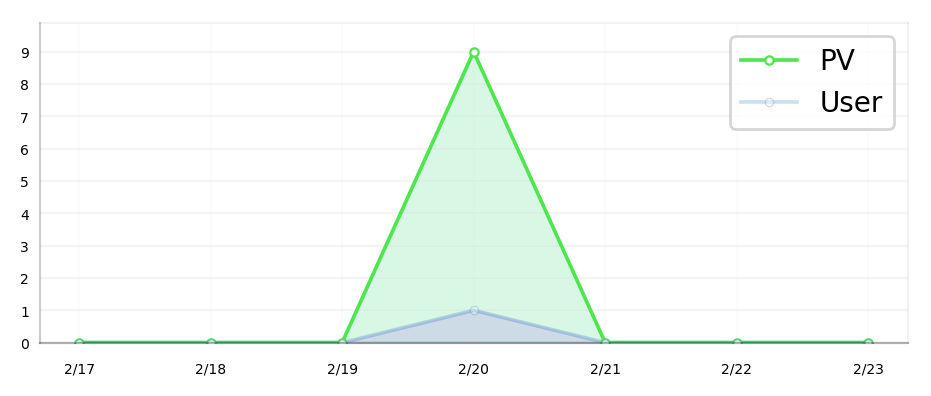

In [39]:
# PV,Userの折れ線グラフ画像出力
# PV,Userの折れ線グラフ画像出力
# PV,Userの折れ線グラフ画像出力
# PV,Userの折れ線グラフ画像出力
# PV,Userの折れ線グラフ画像出力
# PV,Userの折れ線グラフ画像出力

for k, v in df_access_dict.items():
    if df_access_dict[k]['PV'].max() != 0 and df_access_dict[k]['User'].max() != 0:
        fig = plt.figure(figsize=(5.6, 4.4), dpi=200)
        ax = fig.add_subplot(2,1,1)
        plt.fill_between(df_access_dict[k]['PV'].index, df_access_dict[k]['PV'].values, color=[0.7, 0.95, 0.8], alpha=0.5)
        plt.fill_between(df_access_dict[k]['User'].index, df_access_dict[k]['User'].values, color=[0.7, 0.6, 0.9], alpha=0.3)
        pv_max = df_access_dict[k]['PV'].max()*1.1
        user_max = df_access_dict[k]['User'].max()*1.1
        pv_y_max = int(df_access_dict[k]['PV'].max()/4)
        user_y_max = int(df_access_dict[k]['User'].max()/4)

        res1 = user_max if user_max > pv_max else pv_max
        y_min = -0.5 if res1 > 40 else 0
        plt.ylim(y_min, res1)
        plt.xlim()

        y_max = user_y_max if user_y_max > pv_y_max else pv_y_max
        if res1 > 20:
            while y_max % 10 != 0:
                y_max += 1
            plt.yticks(np.arange(0, res1, y_max), x=0.01)
        elif res1 > 10:
            plt.yticks(np.arange(0, res1, 2), x=0.01)
        else:
            plt.yticks(np.arange(0, res1, 1), x=0.01)

        ax.plot(
            df_access_dict[k]['PV'],
            label='PV', 
            color=[0.3, 0.9, 0.3],
            linestyle='solid',
            linewidth=1.3,
            marker='o',
            markersize=3,
            markerfacecolor=[1.0, 1.0, 1.0],
            markeredgewidth=0.8,
            solid_joinstyle='bevel',
        )
        ax.plot(
            df_access_dict[k]['User'],
            label='User',
            color=[0.3, 0.6, 0.8],
            linestyle='solid',
            linewidth=1.3,
            alpha=0.3,
            marker='o',
            markersize=3,
            markerfacecolor=[1.0, 1.0, 1.0],
            markeredgewidth=0.5,
        )

        ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
        ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)

        ax.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1.3, fontsize=6)

        plt.gca().spines['top'].set_alpha(0.05)
        plt.gca().spines['right'].set_alpha(0.05)
        plt.gca().spines['left'].set_alpha(0.2)
        plt.gca().spines['bottom'].set_alpha(0.3)

        y_labels = ax.get_yticklabels()
        x_labels = ax.get_xticklabels()
        plt.setp(y_labels, rotation=0, fontsize=6)
        plt.setp(x_labels, rotation=0, fontsize=6)

        plt.tick_params(
            left=False,
            bottom=False,
            labelsize=5,
        )
        ax.legend()
        filename = k + '_pv_week'
        plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9)
        plt.savefig(ANALYTICS_IMAGE_FILE_PATH + filename, bbox_inches="tight", pad_inches=0.0)

IndexError: string index out of range

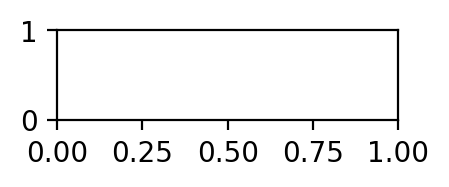

In [40]:
# PVの棒グラフ出力

# PV,Userの折れ線グラフ画像出力

for k, v in df_access_dict.items():
    if df_access_dict[k]['PV'].max() != 0:
        fig = plt.figure(figsize=(2.2, 1.3), dpi=200)
        ax = fig.add_subplot(2,1,1)

        today_pv = df_access_dict[k]['PV']

        ##ylabel書き換え=>1回実行したら再度一番上から実行すること##
        index_list = []
        for i in today_pv.index:
            day_str = i[5:]
            day = day_str[1:].replace('-', '/') if day_str[0] == '0' else day_str.replace('-', '/')
            index_list.append(day)
        today_pv.index = pd.Index(index_list)

        res = 100 if int(today_pv.max()) < 100 else int(today_pv.max()) * 1.5
        plt.xlim(0, res)

        ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
        ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)

        barh_list = ax.barh(today_pv.index, today_pv, color=[0.5, 0.9, 0.5], alpha=0.7, height=0.7)
        y_labels = ax.get_yticklabels()
        x_labels = ax.get_xticklabels()
        plt.setp(y_labels, rotation=0, fontsize=3)
        plt.setp(x_labels, rotation=0, fontsize=3)
        plt.gca().spines['top'].set_alpha(0.05)
        plt.gca().spines['right'].set_alpha(0.05)
        plt.gca().spines['left'].set_alpha(0.2)
        plt.gca().spines['bottom'].set_alpha(0.3)
        plt.tick_params(
            left=False,
            bottom=False,
            labelsize=4,
        )

        filename = k + '_pv_week_bar'
        plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9)
        plt.savefig(ANALYTICS_IMAGE_FILE_PATH + filename, bbox_inches="tight", pad_inches=0.0)

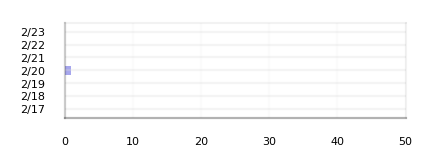

In [28]:
# Userの棒グラフ出力

# PV,Userの折れ線グラフ画像出力

for k, v in df_access_dict.items():
    if df_access_dict[k]['User'].max() != 0:
        fig = plt.figure(figsize=(2.2, 1.3), dpi=200)
        ax = fig.add_subplot(2,1,1)

        today_user = df_access_dict[k]['User']

        ##ylabel書き換え=>1回実行したら再度一番上から実行すること##
        index_list = []
        for i in today_user.index:
            day_str = i[5:]
            day = day_str[1:].replace('-', '/') if day_str[0] == '0' else day_str.replace('-', '/')
            index_list.append(day)
        today_user.index = pd.Index(index_list)

        res = 50 if int(today_user.max()) < 50 else int(today_user.max()) * 1.5
        plt.xlim(0, res)

        ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
        ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)

        barh_list = ax.barh(today_user.index, today_user, color=[0.5, 0.5, 0.9], alpha=0.7, height=0.7)
        y_labels = ax.get_yticklabels()
        x_labels = ax.get_xticklabels()
    #     plt.setp(y_labels, rotation=0, fontsize=3)
        plt.setp(x_labels, rotation=0, fontsize=6)
        plt.gca().spines['top'].set_alpha(0.05)
        plt.gca().spines['right'].set_alpha(0.05)
        plt.gca().spines['left'].set_alpha(0.2)
        plt.gca().spines['bottom'].set_alpha(0.3)
        plt.tick_params(
            left=False,
            bottom=False,
            labelsize=4,
        )

        filename = k + '_user_week_bar'
        plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9)
        plt.savefig(ANALYTICS_IMAGE_FILE_PATH + filename, bbox_inches="tight", pad_inches=0.0)

In [29]:
# AccessAnalyticsに書き込み用

# def insertAnalyticsData(conn, values):
#     sql = ''' INSERT INTO blog_accessanalytics(
#         blog_pk,
#         blog_name,
#         blog_owner,
#         blog_url,
#         total_pv,
#         month_pv,
#         week_pv,
#         day_pv,
#         total_user,
#         month_user,
#         week_user,
#         day_user,
#         created_at
#     ) VALUES(
#         null,
#         ?,
#         null,
#         null,
#         null,
#         null,
#         null,
#         ?,
#         null,
#         null,
#         null,
#         ?,
#         ?
#     )'''
#     cur = conn.cursor()
#     cur.execute(sql, values)
#     return cur.lastrowid

def insertAnalyticsData(conn, values):
    sql = ''' INSERT INTO blog_accessanalytics(
        blog_name,
        week_pv,
        day_pv,
        week_user,
        day_user,
        created_at
    ) VALUES(
        ?,
        ?,
        ?,
        ?,
        ?,
        ?
    )'''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

In [30]:
conn = create_connection(DB_FILE_PATH)
with conn:
    for k, v in df_access_dict.items():
        if df_access_dict[k]['PV'].max() != 0 and df_access_dict[k]['User'].max() != 0:
            today_pv = int(v.loc[today.strftime('%Y-%m-%d'), 'PV'])
            today_user = int(v.loc[today.strftime('%Y-%m-%d'), 'User'])
            week_pv = int(v.PV.sum())
            week_user = int(v.User.sum())
            now_date = datetime.now()
            values = (k, week_pv, today_pv, week_user, today_user, now_date)
            print(values)
            insertAnalyticsData(conn, values)

("takizawa's blog", 9, 0, 1, 0, datetime.datetime(2020, 2, 23, 13, 42, 2, 438319))


In [31]:
# # デザイン用スペース

# fig = plt.figure(figsize=(6.0, 4.0), dpi=200)
# ax = fig.add_subplot(2,1,1)

# ax.plot(
#     df_access_dict["test's blog"]['PV'],
#     label='PV', 
#     color=[0.3, 0.9, 0.3],
#     linestyle='solid',
#     linewidth=1.3,
#     marker='o',
#     markersize=3,
#     markerfacecolor=[1.0, 1.0, 1.0],
#     markeredgewidth=0.8,
#     solid_joinstyle='bevel',
# )
# ax.plot(
#     df_access_dict["test's blog"]['User'],
#     label='User',
#     color=[0.3, 0.4, 0.8],
#     linestyle='solid',
#     linewidth=1.3,
#     alpha=0.3,
#     marker='o',
#     markersize=3,
#     markerfacecolor=[1.0, 1.0, 1.0],
#     markeredgewidth=0.5,
# )
# ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
# ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)
# # ax.legend(bbox_to_anchor=(0,1), loc='upper left', borderaxespad=1.2, fontsize=6)
# ax.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1.3, fontsize=6)

# plt.fill_between(df_access_dict["test's blog"]['PV'].index, df_access_dict["test's blog"]['PV'].values, color=[0.7, 0.95, 0.8], alpha=0.5)
# plt.fill_between(df_access_dict["test's blog"]['User'].index, df_access_dict["test's blog"]['User'].values, color=[0.7, 0.6, 0.9], alpha=0.3)
# plt.ylim(0, df_access_dict["test's blog"]['PV'].max()*1.1)
# plt.xlim()
# pv_max = df_access_dict["test's blog"]['PV'].max()*1.1
# y_max = int(df_access_dict["test's blog"]['PV'].max()/4)
# while y_max % 10 != 0:
#     y_max += 1
# plt.yticks(np.arange(0, pv_max, y_max), x=0.01)
# # plt.gca().spines['top'].set_visible(False)
# # plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_alpha(0.05)
# plt.gca().spines['right'].set_alpha(0.05)
# plt.gca().spines['left'].set_alpha(0.2)
# plt.gca().spines['bottom'].set_alpha(0.3)

# y_labels = ax.get_yticklabels()
# x_labels = ax.get_xticklabels()
# plt.setp(y_labels, rotation=0, fontsize=6)
# plt.setp(x_labels, rotation=0, fontsize=6)
# plt.tick_params(
#     left=False,
#     bottom=False,
#     labelsize=5,
# )

# # filename = k + '_week_' + today.strftime('%Y%m%d')
# plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9)

In [32]:
# # デザイン用スペース

# fig = plt.figure(figsize=(8.0, 8.0), dpi=200)
# today_pv = df_access_dict["test's blog"]['PV']
# ax = fig.add_subplot(2,1,1)

# ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
# ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)
# # barh_list = ax.barh(today_pv.index, today_pv, color=[0.3,0.6,0.9], alpha=0.7, height=0.7)
# barh_list = ax.barh(today_pv.index, today_pv, color=[0.5, 0.9, 0.5], alpha=0.7, height=0.7)
# y_labels = ax.get_yticklabels()
# x_labels = ax.get_xticklabels()
# plt.setp(y_labels, rotation=45, fontsize=6)
# plt.setp(x_labels, rotation=0, fontsize=6)
# plt.gca().spines['top'].set_alpha(0.05)
# plt.gca().spines['right'].set_alpha(0.05)
# plt.gca().spines['left'].set_alpha(0.2)
# plt.gca().spines['bottom'].set_alpha(0.3)
# plt.tick_params(
#     left=False,
#     bottom=False,
#     labelsize=7,
# )


# # barh_list[6].set_color('')

In [33]:
# # デザイン用スペース

# fig = plt.figure(figsize=(8.0, 8.0), dpi=200)
# today_pv = df_access_dict["test's blog"]['User']
# ax = fig.add_subplot(2,1,1)

# ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
# ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)
# # barh_list = ax.barh(today_pv.index, today_pv, color=[0.3,0.6,0.9], alpha=0.7, height=0.7)
# barh_list = ax.barh(today_pv.index, today_pv, color=[0.5, 0.6, 0.9], alpha=0.7, height=0.7)
# y_labels = ax.get_yticklabels()
# x_labels = ax.get_xticklabels()
# plt.setp(y_labels, rotation=45, fontsize=6)
# plt.setp(x_labels, rotation=0, fontsize=6)
# plt.gca().spines['top'].set_alpha(0.05)
# plt.gca().spines['right'].set_alpha(0.05)
# plt.gca().spines['left'].set_alpha(0.2)
# plt.gca().spines['bottom'].set_alpha(0.3)
# plt.tick_params(
#     left=False,
#     bottom=False,
#     labelsize=7,
# )
# # barh_list[6].set_color('')

In [34]:
# # アクセスないユーザー用

# fig = plt.figure(figsize=(6.0, 4.0), dpi=200)
# ax = fig.add_subplot(2,1,1)

# ax.plot(
#     df_access_dict["test's blog"]['PV'],
#     label='PV', 
#     color=[0.3, 0.9, 0.3],
#     linestyle='solid',
#     linewidth=1.3,
#     marker='o',
#     markersize=3,
#     markerfacecolor=[1.0, 1.0, 1.0],
#     markeredgewidth=0.8,
#     solid_joinstyle='bevel',
# )
# ax.plot(
#     df_access_dict["test's blog"]['User'],
#     label='User',
#     color=[0.3, 0.4, 0.8],
#     linestyle='solid',
#     linewidth=1.3,
#     alpha=0.3,
#     marker='o',
#     markersize=3,
#     markerfacecolor=[1.0, 1.0, 1.0],
#     markeredgewidth=0.5,
# )
# ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
# ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)
# # ax.legend(bbox_to_anchor=(0,1), loc='upper left', borderaxespad=1.2, fontsize=6)
# ax.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1.3, fontsize=6)

# plt.fill_between(df_access_dict["test's blog"]['PV'].index, df_access_dict["test's blog"]['PV'].values, color=[0.7, 0.95, 0.8], alpha=0.5)
# plt.fill_between(df_access_dict["test's blog"]['User'].index, df_access_dict["test's blog"]['User'].values, color=[0.7, 0.6, 0.9], alpha=0.3)
# plt.ylim(-0.8, df_access_dict["test's blog"]['PV'].max()*1.1)
# plt.xlim()
# pv_max = df_access_dict["test's blog"]['PV'].max()*1.1
# y_max = int(df_access_dict["test's blog"]['PV'].max()/4)
# while y_max % 10 != 0:
#     y_max += 1
# plt.yticks(np.arange(0, pv_max, y_max), x=0.01)
# # plt.gca().spines['top'].set_visible(False)
# # plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_alpha(0.05)
# plt.gca().spines['right'].set_alpha(0.05)
# plt.gca().spines['left'].set_alpha(0.2)
# plt.gca().spines['bottom'].set_alpha(0.3)

# y_labels = ax.get_yticklabels()
# x_labels = ax.get_xticklabels()
# plt.setp(y_labels, rotation=0, fontsize=6)
# plt.setp(x_labels, rotation=0, fontsize=6)
# plt.tick_params(
#     left=False,
#     bottom=False,
#     labelsize=5,
# )

# # filename = k + '_week_' + today.strftime('%Y%m%d')
# plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9)

In [35]:
no_access_pv = pd.Series(
    np.zeros(7, dtype=np.int16),
    index=[
        '2/13',
        '2/14',
        '2/15',
        '2/16',
        '2/17',
        '2/18',
        '2/19']
)
no_access_pv

2/13    0
2/14    0
2/15    0
2/16    0
2/17    0
2/18    0
2/19    0
dtype: int16

In [36]:
no_access_user = pd.Series(
    np.zeros(7, dtype=np.int16),
    index=[
        '2/13',
        '2/14',
        '2/15',
        '2/16',
        '2/17',
        '2/18',
        '2/19']
)
no_access_user

2/13    0
2/14    0
2/15    0
2/16    0
2/17    0
2/18    0
2/19    0
dtype: int16

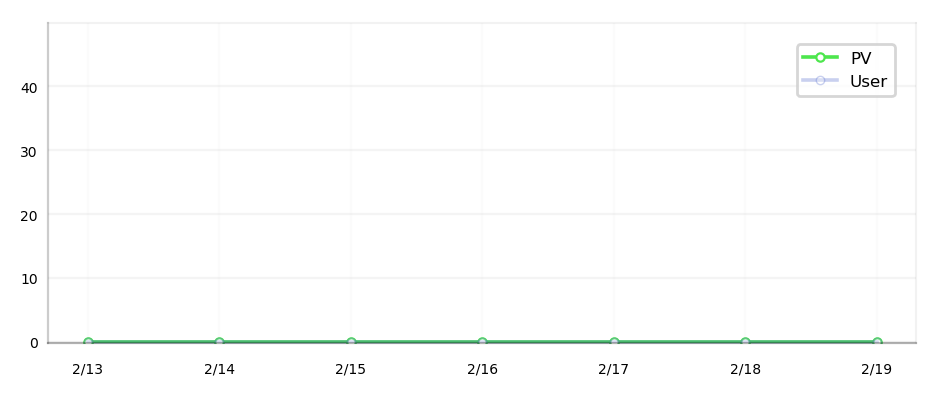

In [37]:
# アクセスないユーザー用

fig = plt.figure(figsize=(5.6, 4.4), dpi=200)
ax = fig.add_subplot(2,1,1)

ax.plot(
    no_access_pv,
    label='PV', 
    color=[0.3, 0.9, 0.3],
    linestyle='solid',
    linewidth=1.3,
    marker='o',
    markersize=3,
    markerfacecolor=[1.0, 1.0, 1.0],
    markeredgewidth=0.8,
    solid_joinstyle='bevel',
)
ax.plot(
    no_access_user,
    label='User',
    color=[0.3, 0.4, 0.8],
    linestyle='solid',
    linewidth=1.3,
    alpha=0.3,
    marker='o',
    markersize=3,
    markerfacecolor=[1.0, 1.0, 1.0],
    markeredgewidth=0.5,
)
ax.grid(axis='y', c='gainsboro', zorder=1, alpha=0.3)
ax.grid(axis='x', c='gainsboro', zorder=1, alpha=0.1)
# ax.legend(bbox_to_anchor=(0,1), loc='upper left', borderaxespad=1.2, fontsize=6)
ax.legend(bbox_to_anchor=(1,1), loc='upper right', borderaxespad=1.3, fontsize=6)

plt.fill_between(no_access_pv.index, no_access_pv.values, color=[0.7, 0.95, 0.8], alpha=0.5)
plt.fill_between(no_access_user.index, no_access_user.values, color=[0.7, 0.6, 0.9], alpha=0.3)
plt.ylim(-0.1, 50)
plt.xlim()
# pv_max = no_access_pv.max()*1.1
# y_max = int(no_access_pv.max()/4)
# while y_max % 10 != 0:
#     y_max += 1
plt.yticks(np.arange(0, 50, 10), x=0.01)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_alpha(0.05)
plt.gca().spines['right'].set_alpha(0.05)
plt.gca().spines['left'].set_alpha(0.2)
plt.gca().spines['bottom'].set_alpha(0.3)

y_labels = ax.get_yticklabels()
x_labels = ax.get_xticklabels()
plt.setp(y_labels, rotation=0, fontsize=6)
plt.setp(x_labels, rotation=0, fontsize=6)
plt.tick_params(
    left=False,
    bottom=False,
    labelsize=5,
)

# filename = k + '_week_' + today.strftime('%Y%m%d')
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9)
filename = 'no_access_week'
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9)
plt.savefig(ANALYTICS_IMAGE_FILE_PATH + filename, bbox_inches="tight", pad_inches=0.0)